In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score, learning_curve, KFold
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier



In [25]:
df_seq_pathHFiltNorm = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt'
df_seq_HFiltNorm = pd.read_csv(df_seq_pathHFiltNorm, delimiter=' ')

In [26]:
df_seq_HFiltNorm.shape

(3000, 182)

In [27]:
df_seq_HFiltNormT = df_seq_HFiltNorm.T

In [28]:
df_seq_HFiltNormT.head()

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,MST1R,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2
output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam,0,48,0,321,298,82,6250,634,0,0,...,78,10,136,0,0,29,0,29,0,0
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam,8739,2101,55,96,1824,1938,62,0,522,413,...,279,0,264,0,134,68,0,213,0,0
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam,13098,14032,0,0,1616,247,430,907,348,0,...,311,0,38,0,0,0,0,92,0,0
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam,2880,356,0,6211,3,3430,79,1953,592,176,...,125,0,16,0,4,1,0,1,0,0
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam,7777,5661,4383,0,145,4618,246,85,206,0,...,268,1,25,0,0,0,0,128,0,0


In [29]:
#we now add the target variable
df_metaH_path = '../ai_lab/SmartSeq/HCC1806_SmartS_MetaData.tsv'
df_metaH = pd.read_csv(df_metaH_path, delimiter='\t')

In [30]:
def add_target_column(data, metadata_path, target_column_name, target_category):
    df_meta = pd.read_csv(metadata_path, delimiter='\t')
    df_meta.set_index('Filename', inplace=True)
    merged_transition = pd.merge(data, df_meta[target_column_name], left_index=True, right_index=True)
    dummy_variables = pd.get_dummies(merged_transition[target_column_name], prefix='category').astype('int')
    
    # Set the target category to 1 and the others to 0
    dummy_variables['Target'] = dummy_variables[target_category]
    dummy_variables.drop(columns=[col for col in dummy_variables.columns if col != 'Target'], inplace=True)
    
    merged_data = pd.concat([merged_transition, dummy_variables], axis=1)
    merged_data.drop(columns=[target_column_name], inplace=True)
    return merged_data

In [31]:
df_metaH.head()

,Filename,Cell Line,PCR Plate,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...,HCC1806,1,A10,Normo,24,S123,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....,HCC1806,1,A12,Normo,24,S26,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...,HCC1806,1,A1,Hypo,24,S97,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...,HCC1806,1,A2,Hypo,24,S104,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...,HCC1806,1,A3,Hypo,24,S4,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


In [32]:
traindf = add_target_column(df_seq_HFiltNormT, df_metaH_path, 'Condition', 'category_Normo')

In [33]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, validation_curve
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

X = traindf.drop(columns=['Target'])
y = traindf['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

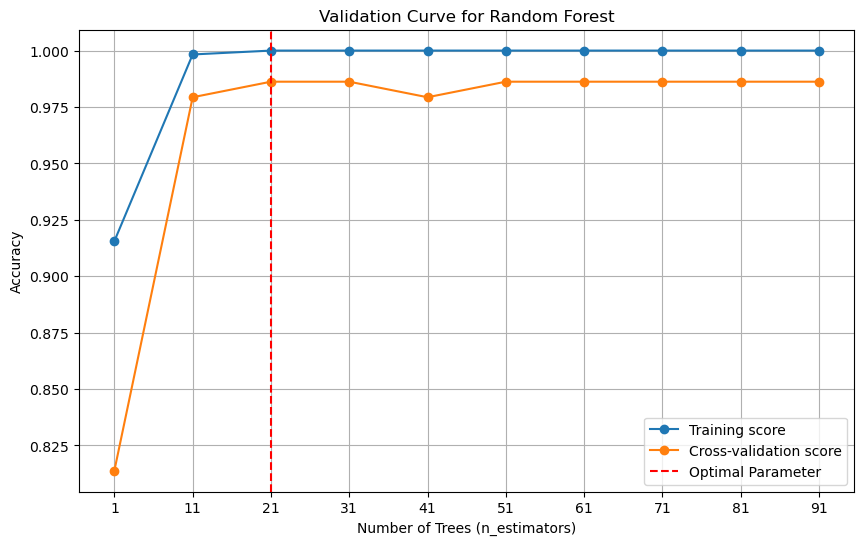

In [34]:
# We start by estimating the most important hyperparameter: the number of trees
param_range = np.arange(1, 100, 10)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)
# Plot the learning curve
# Find the optimal parameter
optimal_param = param_range[np.argmax(np.mean(test_scores, axis=1))]

# Plot the learning curve with enhanced appearance
plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score', marker='o', linestyle='-')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score', marker='o', linestyle='-')
plt.axvline(x=optimal_param, color='red', linestyle='--', label='Optimal Parameter')
plt.title('Validation Curve for Random Forest')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(param_range)
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# We proceed to do a grid search to find the optimal hyperparameters with cross-validation
param_grid = {
    'max_depth': np.arange(1, 10, 1),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 10, 1)
}
grid_search = GridSearchCV(RandomForestClassifier(n_estimators = 21, random_state=42), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print('Best hyperparameters:', best_params)

Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [36]:
# Train the model with the best hyperparameters
rf = RandomForestClassifier(n_estimators=21, random_state=42, **best_params)
rf.fit(X_train, y_train)
# Predict y
y_pred = rf.predict(X_test)

In [37]:
# Now evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 1.0


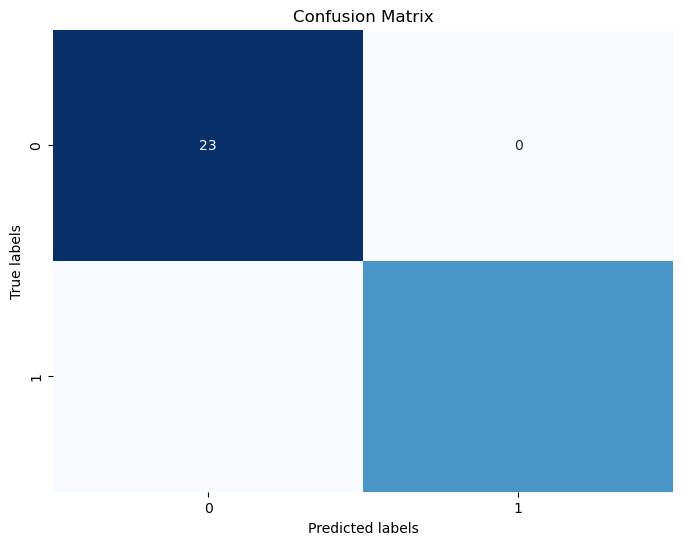

In [38]:
# Confusion matrix
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [39]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        14

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



By evaluating the model on multiple folds, we reduce the bias introduced by a single train-test split. Each fold represents a different partition of the data, ensuring that the model's performance is assessed across a variety of data subsets. This helps in obtaining a more accurate and reliable estimate of the model's performance on unseen data.


Fold 1 Evaluation Scores:
Accuracy: 0.972972972972973
Precision: 0.9333333333333333
Recall: 1.0
F1-score: 0.9655172413793104

Fold 2 Evaluation Scores:
Accuracy: 0.972972972972973
Precision: 1.0
Recall: 0.9473684210526315
F1-score: 0.972972972972973

Fold 3 Evaluation Scores:
Accuracy: 0.9722222222222222
Precision: 0.9411764705882353
Recall: 1.0
F1-score: 0.9696969696969697

Fold 4 Evaluation Scores:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Fold 5 Evaluation Scores:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


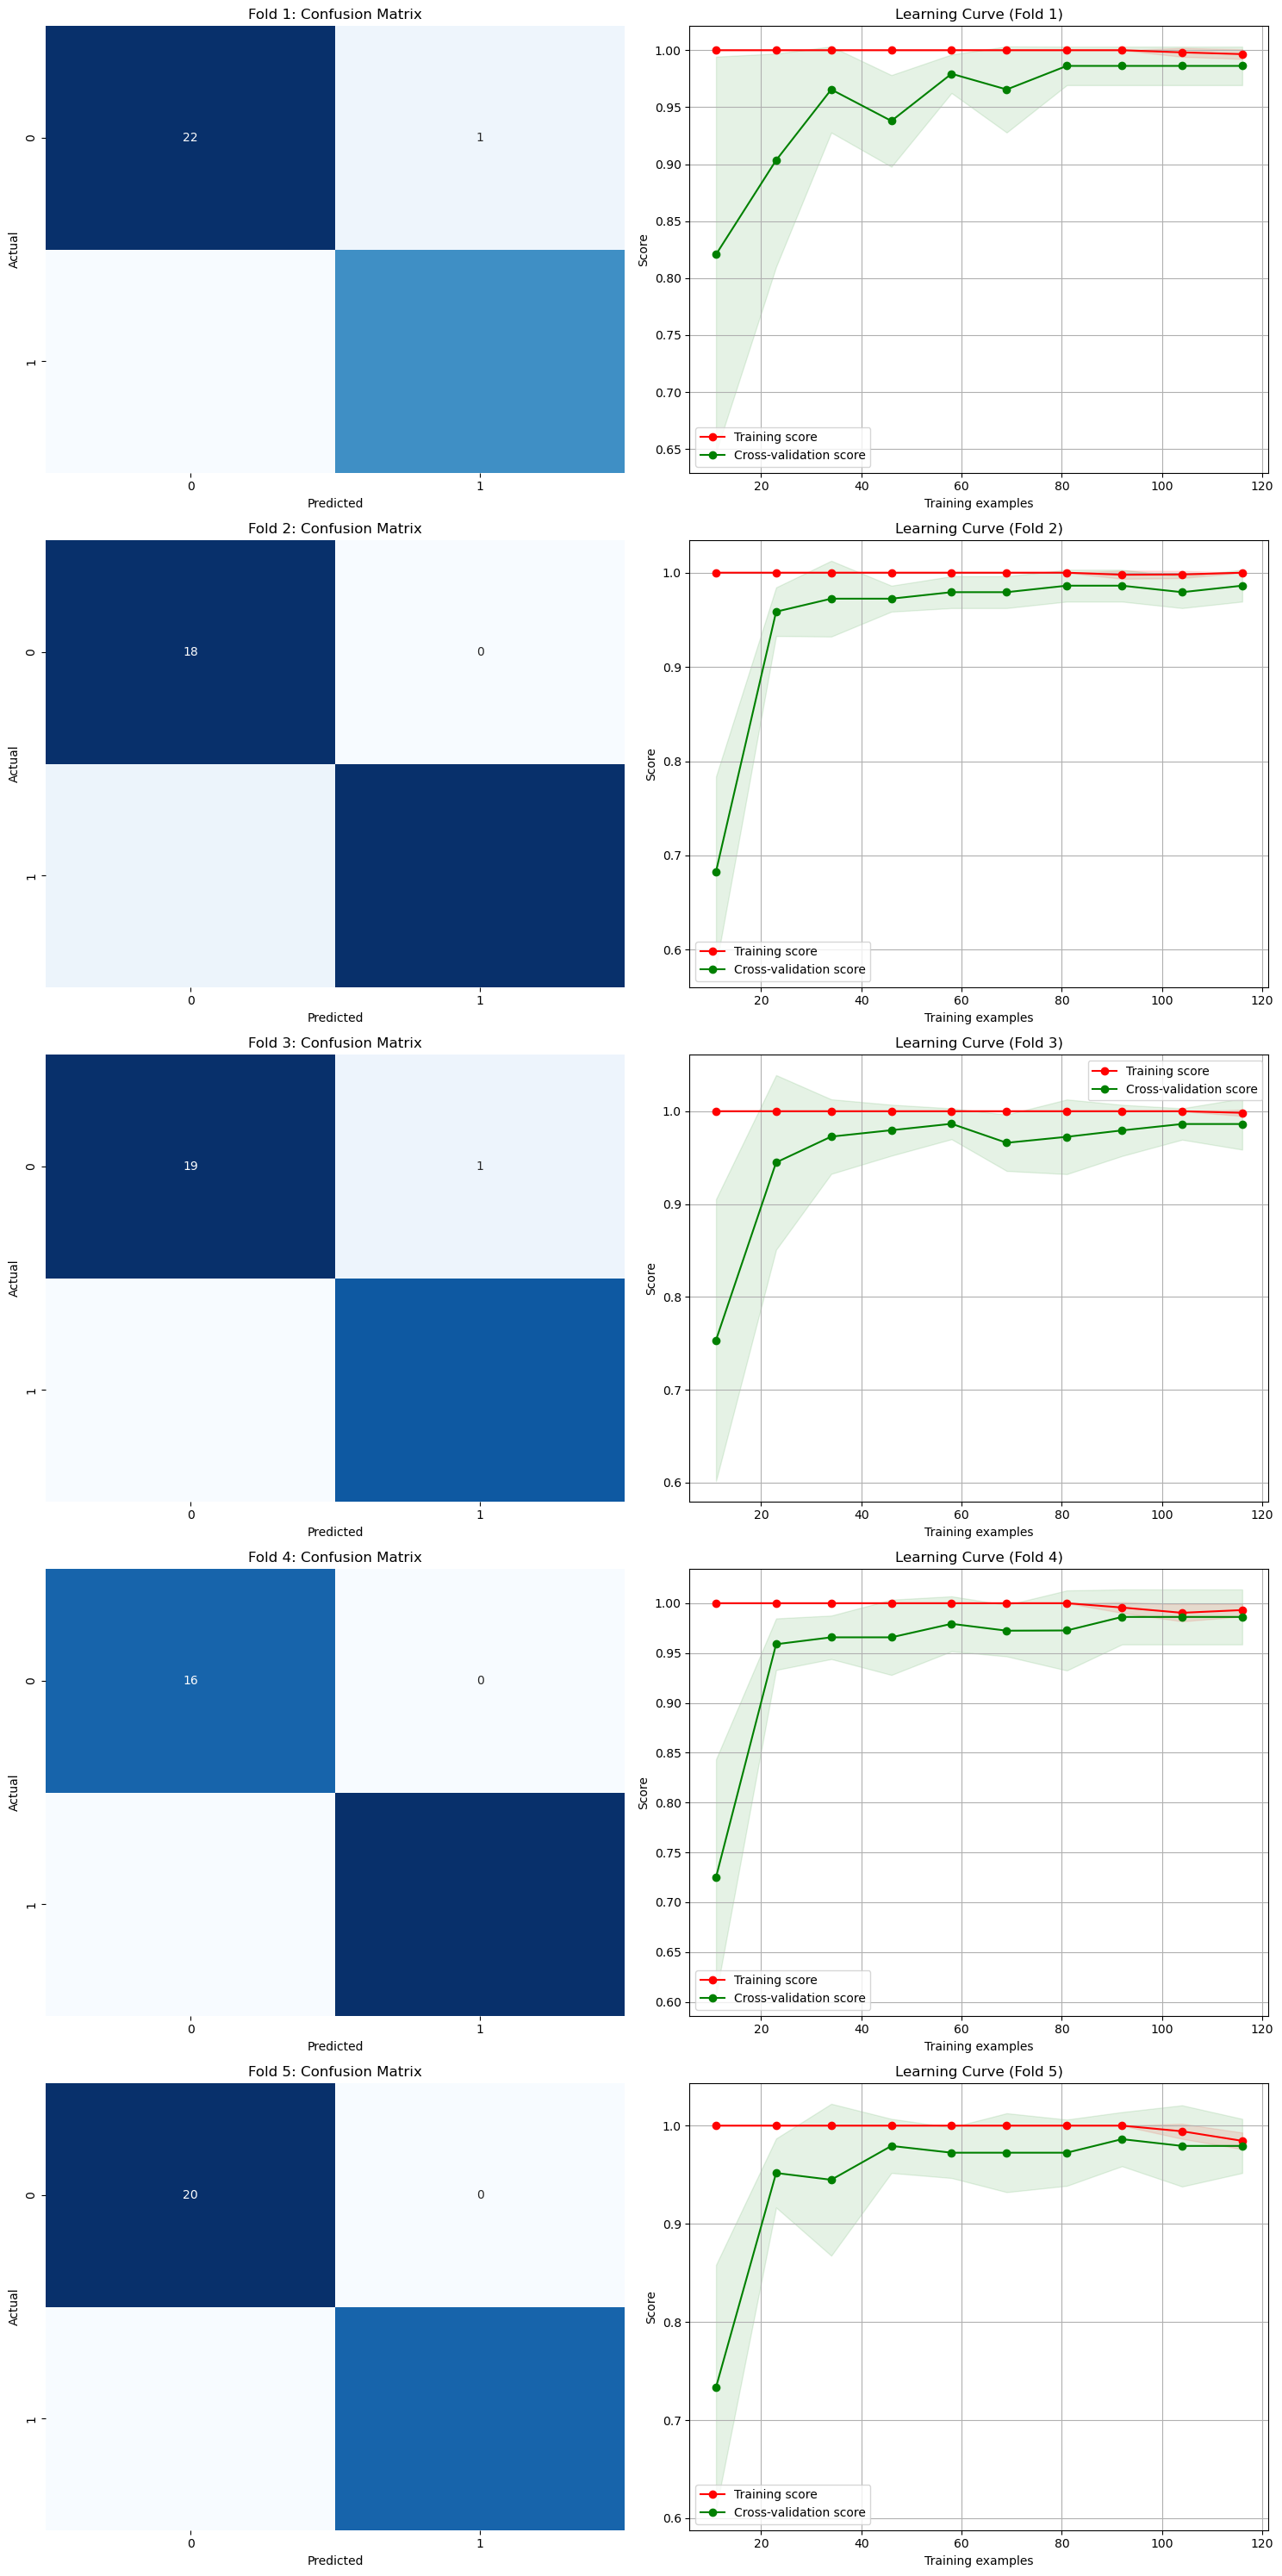


Mean Evaluation Scores Across Folds:
Mean Accuracy: 0.9836336336336338
Mean Precision: 0.9749019607843138
Mean Recall: 0.9894736842105264
Mean F1-score: 0.9816374368098506


In [41]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation scores
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Create subplots for confusion matrices and learning curves
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))

# Iterate over folds
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a Random Forest Classifier model
    rf = RandomForestClassifier(n_estimators=21, random_state=42, **best_params)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = rf.predict(X_test)

    # Calculate evaluation scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append scores to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Print evaluation scores for each fold
    print(f"\nFold {i+1} Evaluation Scores:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, ax=axes[i, 0])
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Actual')
    axes[i, 0].set_title(f'Fold {i+1}: Confusion Matrix')

    # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=kf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    axes[i, 1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i, 1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i, 1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i, 1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[i, 1].set_xlabel("Training examples")
    axes[i, 1].set_ylabel("Score")
    axes[i, 1].set_title(f"Learning Curve (Fold {i+1})")
    axes[i, 1].legend(loc="best")
    axes[i, 1].grid()

plt.tight_layout()
plt.show()

# Print mean evaluation scores across all folds
print("\nMean Evaluation Scores Across Folds:")
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Mean Precision:", np.mean(precision_scores))
print("Mean Recall:", np.mean(recall_scores))
print("Mean F1-score:", np.mean(f1_scores))


In [44]:
# Create a Random Forest Classifier model with the best parameters and enable OOB scoring
rf_best = RandomForestClassifier(n_estimators=21, random_state=42, **best_params, oob_score=True)
# Fit the model to the entire dataset
rf_best.fit(X, y)
# Access the OOB score
oob_accuracy = rf_best.oob_score_
# Print OOB accuracy
print("Out-of-Bag (OOB) Accuracy:", oob_accuracy)

Out-of-Bag (OOB) Accuracy: 0.9725274725274725


In [49]:
# To be added partial dependence plot